# Model Evaluation

This notebook loads the saved models and generates predictions from test dataset. The predictions and model metrics are evaluated, compared, and saved for future examination.

- Generate the test dataset.
- Load the saved models.
- Run the test dataset through the models to generate predictions.
- Evaluate the predictions based on the actual labels.
- Calculate model metrics - Accuracy, Recall, Precision
- Compare the models

In [1]:
# Set up the environment
#!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import soundfile as sf

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [2]:
# Set constants
SAMP_RATE = 16000
BATCH_SIZE = 32
CLF='lang10'
SHUFFLE_SEED = 38

# Modified from https://console.paperspace.com/gcn-team/notebook/prcnk5wzd
# Set model constants
BATCH_SIZE = 32
NUM_EPOCHS=100
DROPOUT = 0.5
EARLY_STOP_AFTER = 5

LOSS = 'categorical_crossentropy'
DENSE_ACTIVATION = 'relu'
FINAL_ACTIVATION = 'softmax'

class_names = os.listdir('storage/data/lang10/train')
class_names.remove('.ipynb_checkpoints')
print("Our class names: {}".format(class_names,))

Our class names: ['russian', 'arabic', 'turkish', 'korean', 'german', 'dutch', 'spanish', 'french', 'english', 'portuguese', 'mandarin']


## Generate Test Dataset

In [3]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

In [4]:
# Process testing data
DATASET_TEST_PATH = 'storage/data/lang10/test/test_data'

test_names = os.listdir(DATASET_TEST_PATH)
test_paths = []
test_labels = []

label_dict = {}
for label, name in enumerate(class_names):
    label_dict[name] = label

for filename in test_names:
    filepath =  os.path.join(DATASET_TEST_PATH, filename)
    test_paths.append(filepath)
    fname = filename.split('.')[0].rstrip('0123456789')
    test_labels.append(label_dict[fname])

In [5]:
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

In [6]:
test_onehot = tf.keras.backend.one_hot(test_labels, num_classes = len(class_names))

In [7]:
print(type(test_onehot) )
print(test_onehot.shape)
print(test_onehot[0])

<class 'tensorflow.python.framework.ops.EagerTensor'>
(373, 11)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)


In [8]:
print("Number of testing samples: ", len(test_paths))

EVAL_STEPS = np.int(np.ceil(len(test_paths)/BATCH_SIZE))-1
print("evaluation_steps = ", EVAL_STEPS)

Number of testing samples:  373
evaluation_steps =  11


In [9]:
def tf_data_generator(file_list, label_list, batch_size=32):
    '''
    Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    label_list - list of the labels associated with the files
    batch_size - how many files to process at a time
    '''
    i = 1
    shuff_seed = 42
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=1
            rng = np.random.RandomState(shuff_seed)
            rng.shuffle(file_list)
            rng = np.random.RandomState(shuff_seed)
            rng.shuffle(label_list)
            shuff_seed += 1
        else:
            file_chunk = file_list[(i-1)*batch_size:i*batch_size]
            labels = label_list[(i-1)*batch_size:i*batch_size, :]
            data = []

            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [10]:
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [test_paths, test_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) ) 

In [11]:
def create_lang_model(n_layers, n_nodes):
    model = Sequential()
    model.add(Input(shape=(10, 128), batch_size=BATCH_SIZE ))
    
    for i in range(n_layers):
        model.add(Dense(n_nodes/(2**i), activation=DENSE_ACTIVATION))
        model.add(Dropout(DROPOUT))

    model.add(Flatten())
    # Output
    model.add(Dense(11, activation=FINAL_ACTIVATION) )

    model.compile(loss=LOSS, optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
    return model

In [12]:
def evaluate_model(model, model_name, test_ds):
    # Evaluate the model
    #val_loss, val_acc, val_prec, val_recall = model.evaluate(val_ds, steps=VAL_STEPS)
    #test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds, steps=EVAL_STEPS)
    
    y_pred = model.predict(test_ds, steps=EVAL_STEPS)
    y_pred_ind = np.argmax(y_pred, axis=1)
    
    # Get 1D array of labels from test_dataset
    y_lab = np.concatenate([y for x, y in test_ds.take(EVAL_STEPS)], axis=0)
    y_lab_ind = np.argmax(y_lab, axis=1)

    fig_path = ('storage/figures/lang10/{}'.format(model_name))

    conf_mat = tf.math.confusion_matrix(y_lab_ind, y_pred_ind)
    print(conf_mat)
    sns.heatmap(conf_mat, annot = True, cmap='YlGnBu')
    plt.title("Confusion matrix: {}".format(model_name))
    plt.savefig('{}.ConfusionMatrix.png'.format(fig_path))

    return y_lab, y_pred_ind

# Model 1
Nodes equal to 1% the size of the input: 
0.01 * 10 x 128 = 12

In [13]:
# Set model constants
n_layers = 1
n_nodes = int(10 * 128 * 0.01)
print(n_nodes)

model1_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model1_path = 'storage/models/lang10/{}'.format(model1_name)
ckpt1_name = '{}.ckpt'.format(model1_name)
ckpt1_path = 'storage/models/lang10/{}'.format(ckpt1_name)
ckpt1_dir = os.path.dirname(ckpt1_path)

12


In [14]:
if os.path.isdir(model1_path):
    model1 = tf.keras.models.load_model(model1_path)
    print("Saved model loaded")
    model1.summary()
elif os.path.isdir(ckpt1_path):
    model1 = create_lang_model(n_layers, n_nodes)
    model1.load_weights(ckpt1_path)
    print("Model weights loaded")
    model1.summary()

Saved model loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 10, 12)              1548      
_________________________________________________________________
dropout (Dropout)            (32, 10, 12)              0         
_________________________________________________________________
flatten (Flatten)            (32, 120)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 11)                  1331      
Total params: 2,879
Trainable params: 2,879
Non-trainable params: 0
_________________________________________________________________


In [15]:
test1_loss, test1_acc, test1_prec, test1_recall = model1.evaluate(test_dataset, steps=EVAL_STEPS)

11/11 [==============================] - 71s 6s/step - loss: 2.2549 - accuracy: 0.2330 - precision: 0.6250 - recall: 0.0142


tf.Tensor(
[[ 1  9  0  0  0  0  4  1  2  4  7]
 [ 0 27  0  2  0  4  3  0  2  0 17]
 [ 1  2  2  3  1  2  4  1  1  2  2]
 [ 2 10  1  0  0  0  4  1  2  1 10]
 [ 0  0  1  2  0  0  2  0  5  2  3]
 [ 0  4  1  0  1  3  5  0  5  0  6]
 [ 1  8  5  0  2  0 10  1  8  2  5]
 [ 0  8  0  1  0  0  6  4  2  2  9]
 [ 0  2  0  4  0  0  1  1 19  2  1]
 [ 1  7  1  3  0  0  2  5  2  1  6]
 [ 0  2  4  3  0  1  8  5  3  4 15]], shape=(11, 11), dtype=int32)


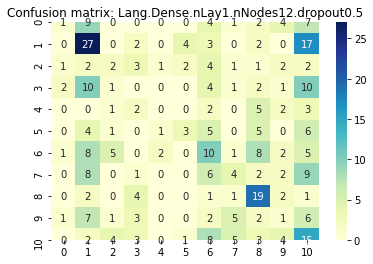

In [16]:
y1_lab, y1_pred_ind = evaluate_model(model1, model1_name, test_dataset)

# Model 2
Nodes equal to 10% the size of the (2D) input: 
0.1 * 10 x 128 = 128

In [17]:
# Set model constants
n_layers = 1
n_nodes = int(10 * 128 * 0.1)
print(n_nodes)

model2_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model2_path = 'storage/models/lang10/{}'.format(model2_name)
ckpt2_name = '{}.ckpt'.format(model2_name)
ckpt2_path = 'storage/models/lang10/{}'.format(ckpt2_name)
ckpt2_dir = os.path.dirname(ckpt2_path)

128


In [18]:
if os.path.isdir(model2_path):
    model2 = tf.keras.models.load_model(model2_path)
    print("Saved model loaded")
    model2.summary()
elif os.path.isdir(ckpt2_path):
    model2 = create_lang_model(n_layers, n_nodes)
    model2.load_weights(ckpt2_path)
    print("Model weights loaded")
    model2.summary()

Saved model loaded
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (32, 10, 128)             16512     
_________________________________________________________________
dropout_1 (Dropout)          (32, 10, 128)             0         
_________________________________________________________________
flatten_1 (Flatten)          (32, 1280)                0         
_________________________________________________________________
dense_3 (Dense)              (32, 11)                  14091     
Total params: 30,603
Trainable params: 30,603
Non-trainable params: 0
_________________________________________________________________


In [19]:
test2_loss, test2_acc, test2_prec, test2_recall = model2.evaluate(test_dataset, steps=EVAL_STEPS)

11/11 [==============================] - 70s 6s/step - loss: 2.3230 - accuracy: 0.2386 - precision_1: 0.5000 - recall_1: 0.0739


tf.Tensor(
[[ 1  2  2  0  3  0  4  4  1  3  8]
 [ 0 26  0  0  2  6  4  0  3  1 13]
 [ 1  2  2  2  1  4  4  1  1  1  2]
 [ 5  4  2  4  0  3  4  1  1  3  4]
 [ 1  0  0  0  0  1  3  2  4  3  1]
 [ 1  1  1  0  1 12  1  1  3  2  2]
 [ 3  1  3  0  4  2  6  2 10  2  9]
 [ 2  4  1  2  1  1  9  3  3  2  4]
 [ 1  1  0  1  0  3  2  0 15  0  7]
 [ 7  3  1  3  1  1  1  2  4  1  4]
 [ 1  0  3  5  1  5  9  3  3  1 14]], shape=(11, 11), dtype=int32)


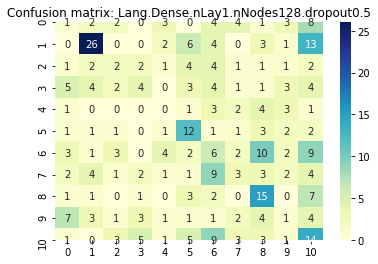

In [20]:
y2_lab, y2_pred_ind = evaluate_model(model2, model2_name, test_dataset)

# Model 3
2 layers, first with 128, second with 64

In [21]:
# Set model constants
n_layers = 2
n_nodes = int(10 * 128 * 0.1)
print(n_nodes)

model3_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model3_path = 'storage/models/lang10/{}'.format(model3_name)
ckpt3_name = '{}.ckpt'.format(model3_name)
ckpt3_path = 'storage/models/lang10/{}'.format(ckpt3_name)
ckpt3_dir = os.path.dirname(ckpt3_path)

128


In [22]:
if os.path.isdir(model3_path):
    model3 = tf.keras.models.load_model(model3_path)
    print("Saved model loaded")
    model3.summary()
elif os.path.isdir(ckpt3_path):
    model3 = create_lang_model(n_layers, n_nodes)
    model3.load_weights(ckpt3_path)
    print("Model weights loaded")
    model3.summary()

Saved model loaded
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (32, 10, 128)             16512     
_________________________________________________________________
dropout_2 (Dropout)          (32, 10, 128)             0         
_________________________________________________________________
dense_5 (Dense)              (32, 10, 64)              8256      
_________________________________________________________________
dropout_3 (Dropout)          (32, 10, 64)              0         
_________________________________________________________________
flatten_2 (Flatten)          (32, 640)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 11)                  7051      
Total params: 31,819
Trainable params: 31,819
Non-trainable params: 0
_______________________________

In [23]:
test3_loss, test3_acc, test3_prec, test3_recall = model3.evaluate(test_dataset, steps=EVAL_STEPS)

11/11 [==============================] - 68s 6s/step - loss: 2.2068 - accuracy: 0.2500 - precision_2: 0.6053 - recall_2: 0.0653


tf.Tensor(
[[ 0  2  1  4  0  1  7  4  1  1  7]
 [ 0 24  0  4  1  7  2  2  4  0 11]
 [ 0  1  1  4  0  3  4  0  2  1  5]
 [ 1 10  0  6  0  3  2  2  4  2  1]
 [ 0  0  0  1  0  0  5  1  5  2  1]
 [ 0  4  0  0  0 12  3  1  3  1  1]
 [ 1  2  0  6  2  1 12  3  8  0  7]
 [ 1  3  0  4  1  2 10  5  1  1  4]
 [ 0  1  0  3  0  5  2  2 13  0  4]
 [ 0  3  0  3  1  0  7  5  3  0  6]
 [ 0  2  0  8  2  4  9  1  2  2 15]], shape=(11, 11), dtype=int32)


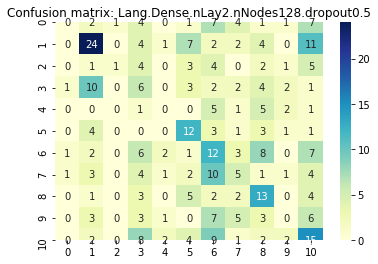

In [24]:
y3_lab, y3_pred_ind = evaluate_model(model3, model3_name, test_dataset)

# Examine labels and predictions lists
## Model 1 predictions

In [25]:
y1_lab_ind = np.argmax(y1_lab, axis=1)
print(y1_lab_ind[:10])
print(len(y1_lab_ind))

[ 3 10  6 10  6  7  9  2  1  9]
352


In [28]:
print(y1_pred_ind[:10])
print(len(y1_pred_ind))

[ 1 10  1 10  6  6  1  6  1  8]
352


In [29]:
# Number of time each label was predicted
y1_pred_count = {}
for lab in y1_pred_ind:
    if lab in y1_pred_count.keys():
        y1_pred_count[lab] += 1
    else: y1_pred_count[lab] = 1

print(y1_pred_count.items())

dict_items([(1, 79), (10, 81), (6, 49), (8, 51), (4, 4), (3, 18), (5, 10), (2, 15), (7, 19), (9, 20), (0, 6)])


## Model 2 predictions

In [26]:
y2_lab_ind = np.argmax(y2_lab, axis=1)
print(y2_lab_ind[:10])

[ 3 10  6 10  6  7  9  2  1  9]


In [30]:
print(y2_pred_ind[:10])

[ 3 10  2 10 10  6  8  6  1  0]


In [ ]:
# Number of time each label was predicted
y2_pred_count = {}
for lab in y2_pred_ind:
    if lab in y2_pred_count.keys():
        y2_pred_count[lab] += 1
    else: y2_pred_count[lab] = 1

print(y2_pred_count.items())

## Model 3 predictions

In [27]:
y3_lab_ind = np.argmax(y3_lab, axis=1)
print(y3_lab_ind[:10])

[ 3 10  6 10  6  7  9  2  1  9]


In [31]:
print(y3_pred_ind[:10])

[ 3 10  3 10 10  6  8  6  1  8]


In [ ]:
# Number of time each label was predicted
y3_pred_count = {}
for lab in y3_pred_ind:
    if lab in y3_pred_count.keys():
        y3_pred_count[lab] += 1
    else: y3_pred_count[lab] = 1

print(y3_pred_count.items())

# Calculate F1 scores

In [32]:
m1_f1_micro = f1_score(y1_lab_ind, y1_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='micro')
m1_f1_macro = f1_score(y1_lab_ind, y1_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='macro')
m1_f1_weight = f1_score(y1_lab_ind, y1_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='weighted')
print(m1_f1_micro)
print(m1_f1_macro)
print(m1_f1_weight)

0.23295454545454544
0.1699899053352375
0.20066957123860105


In [33]:
m2_f1_micro = f1_score(y2_lab_ind, y2_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='micro')
m2_f1_macro = f1_score(y2_lab_ind, y2_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='macro')
m2_f1_weight = f1_score(y2_lab_ind, y2_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='weighted')
print(m2_f1_micro)
print(m2_f1_macro)
print(m2_f1_weight)

0.23863636363636365
0.19551209786173598
0.2281782904462841


In [34]:
m3_f1_micro = f1_score(y3_lab_ind, y3_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='micro')
m3_f1_macro = f1_score(y3_lab_ind, y3_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='macro')
m3_f1_weight = f1_score(y3_lab_ind, y3_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], average='weighted')
print(m3_f1_micro)
print(m3_f1_macro)
print(m3_f1_weight)

0.25
0.19110304657302432
0.22456546138515254


# Classification Reports

In [35]:
y1_report = classification_report(y1_lab_ind, y1_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)
classification_report(y1_lab_ind, y1_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)

'              precision    recall  f1-score   support\n\n     russian       0.17      0.04      0.06        28\n      arabic       0.34      0.49      0.40        55\n     turkish       0.13      0.10      0.11        21\n      korean       0.00      0.00      0.00        31\n      german       0.00      0.00      0.00        15\n       dutch       0.30      0.12      0.17        25\n     spanish       0.20      0.24      0.22        42\n      french       0.21      0.12      0.16        32\n     english       0.37      0.63      0.47        30\n  portuguese       0.05      0.04      0.04        28\n    mandarin       0.19      0.33      0.24        45\n\n    accuracy                           0.23       352\n   macro avg       0.18      0.19      0.17       352\nweighted avg       0.20      0.23      0.20       352\n'

In [36]:
y2_report = classification_report(y2_lab_ind, y2_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)
classification_report(y2_lab_ind, y2_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)

'              precision    recall  f1-score   support\n\n     russian       0.04      0.04      0.04        28\n      arabic       0.59      0.47      0.53        55\n     turkish       0.13      0.10      0.11        21\n      korean       0.24      0.13      0.17        31\n      german       0.00      0.00      0.00        15\n       dutch       0.32      0.48      0.38        25\n     spanish       0.13      0.14      0.13        42\n      french       0.16      0.09      0.12        32\n     english       0.31      0.50      0.38        30\n  portuguese       0.05      0.04      0.04        28\n    mandarin       0.21      0.31      0.25        45\n\n    accuracy                           0.24       352\n   macro avg       0.20      0.21      0.20       352\nweighted avg       0.23      0.24      0.23       352\n'

In [37]:
y3_report = classification_report(y3_lab_ind, y3_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)
classification_report(y3_lab_ind, y3_pred_ind, labels = [0,1,2,3,4,5,6,7,8,9,10], target_names = class_names)

'              precision    recall  f1-score   support\n\n     russian       0.00      0.00      0.00        28\n      arabic       0.46      0.44      0.45        55\n     turkish       0.50      0.05      0.09        21\n      korean       0.14      0.19      0.16        31\n      german       0.00      0.00      0.00        15\n       dutch       0.32      0.48      0.38        25\n     spanish       0.19      0.29      0.23        42\n      french       0.19      0.16      0.17        32\n     english       0.28      0.43      0.34        30\n  portuguese       0.00      0.00      0.00        28\n    mandarin       0.24      0.33      0.28        45\n\n    accuracy                           0.25       352\n   macro avg       0.21      0.22      0.19       352\nweighted avg       0.23      0.25      0.22       352\n'

# Put Results in a dataframe

In [38]:
compare = pd.DataFrame({'layers': [1, 1, 2],
                        'nodes':[12, 128, (128, 64)],
                        'loss': [test1_loss, test2_loss, test3_loss], 
                        'accuracy': [test1_acc, test2_acc, test3_acc], 
                        'precision': [test1_prec, test2_prec, test3_prec], 
                        'recall': [test1_recall, test2_recall, test3_recall],
                       'f1 micro': [m1_f1_micro, m2_f1_micro, m3_f1_micro],
                        'f1 macro': [m1_f1_macro, m2_f1_macro, m3_f1_macro],
                        'f1 weighted': [m1_f1_weight, m2_f1_weight, m3_f1_weight],
                       },
                      index = ['model 1', 'model 2', 'model 3'])

In [39]:
compare.head()

,loss,accuracy,precision,recall,layers,nodes,f1 micro,f1 macro,f1 weighted
model 1,2.254851,0.232955,0.625000,0.014205,1,12,0.232955,0.169990,0.200670
model 2,2.322996,0.238636,0.500000,0.073864,1,128,0.238636,0.195512,0.228178
model 3,2.206843,0.250000,0.605263,0.073864,2,"(128, 64)",0.250000,0.191103,0.224565


In [40]:
compare.to_csv('storage/models/lang10/model_comparison.csv')

In [41]:
compare.T

,model 1,model 2,model 3
loss,2.25485,2.323,2.20684
accuracy,0.232955,0.238636,0.25
precision,0.625,0.5,0.605263
recall,0.0142045,0.0738636,0.0738636
layers,1,1,2
nodes,12,128,"(128, 64)"
f1 micro,0.232955,0.238636,0.25
f1 macro,0.16999,0.195512,0.191103
f1 weighted,0.20067,0.228178,0.224565
